<a href="https://colab.research.google.com/github/bgb83/airline_sentiment_analysis/blob/master/airline_tweet_sentiment_analysis_ulmfit_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ULMFiT Airline Tweets Sentiment Analysis** 

Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 

**Import Required Libraries**

In [0]:
# install pytorch and fastai
!pip3 install torch torchvision
!pip3 install fastai

In [0]:
# import libraries
from fastai.text import *
from fastai.vision import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io

In [0]:
#import dataset
from google.colab import files
uploaded = files.upload()

**Exploratory Data Analysis**

In [0]:
#create a dataframe from csv file and check data (nulls, columns, types)
df = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [0]:
#check how the data looks
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


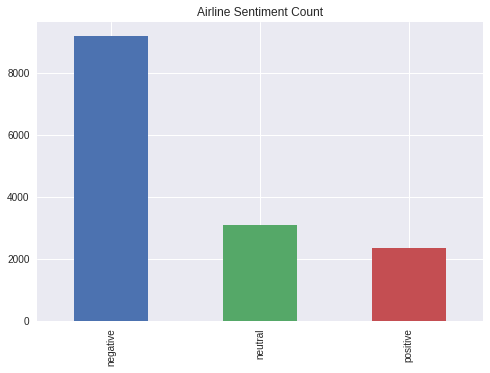

In [0]:
#check labels: airline_sentiment
df.airline_sentiment.value_counts().plot(kind='bar', title='Airline Sentiment Count');

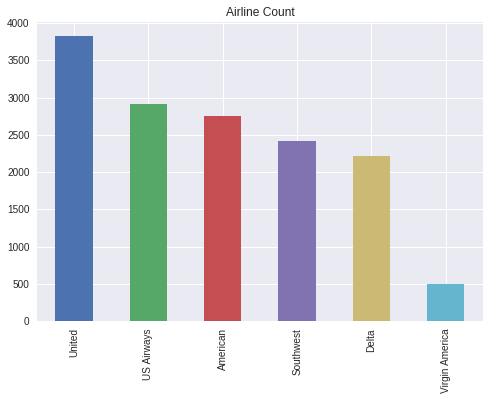

In [0]:
#check airlines
df.airline.value_counts().plot(kind='bar', title='Airline Count');

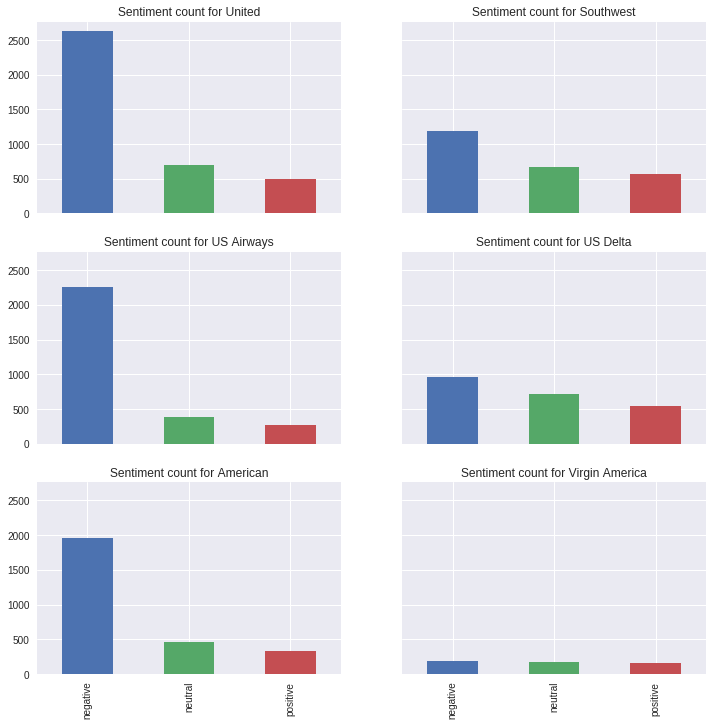

In [0]:
#Check labels per airline
fig, axarr = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

df[df['airline']=='United']['airline_sentiment'].value_counts().sort_values(ascending=False).plot.bar(
    ax=axarr[0][0]
)
axarr[0][0].set_title("Sentiment count for United")

df[df['airline']=='US Airways']['airline_sentiment'].value_counts().sort_values(ascending=False).plot.bar(
    ax=axarr[1][0]
)
axarr[1][0].set_title("Sentiment count for US Airways")

df[df['airline']=='American']['airline_sentiment'].value_counts().sort_values(ascending=False).plot.bar(
    ax=axarr[2][0]
)
axarr[2][0].set_title("Sentiment count for American")

df[df['airline']=='Southwest']['airline_sentiment'].value_counts().sort_values(ascending=False).plot.bar(
    ax=axarr[0][1]
)
axarr[0][1].set_title("Sentiment count for Southwest")

df[df['airline']=='Delta']['airline_sentiment'].value_counts().sort_values(ascending=False).plot.bar(
    ax=axarr[1][1]
)
axarr[1][1].set_title("Sentiment count for US Delta")

df[df['airline']=='Virgin America']['airline_sentiment'].value_counts().sort_values(ascending=False).plot.bar(
    ax=axarr[2][1]
)
axarr[2][1].set_title("Sentiment count for Virgin America");



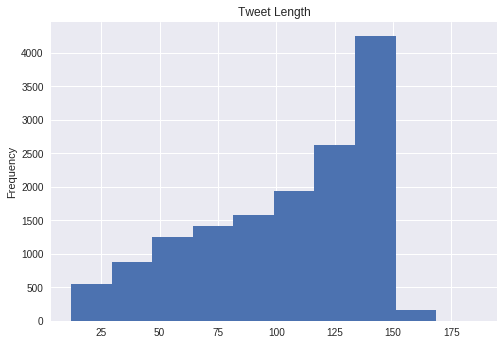

In [0]:
#check tweet length to confirm text size is ok
df['text'].apply(lambda x: len(x)).plot(kind='hist',title="Tweet Length");

In [0]:
#check how tweets look
df['text'].sample(5)

5975     @SouthwestAir I already follow you and can't D...
13803    “@AmericanAir: @nlrphoto Those are very beauti...
14065    @AmericanAir "overweight" flight = you sold mo...
11551    @USAirways Thx to gate agt John Pascucci for f...
1144     @united shes been rescheduled for today, but w...
Name: text, dtype: object

We can clearly see that most tweets are negative and neutral and positive tweets are more or less balanced. To make classification more accurate, I combined neutral and positive tweets. This results in a binary classification problem with relatively balanced classes.

**Preprocess Data for ULMfiT**

In [0]:
# create dataframe consisting of labels and text only as suggested by Yann LeCun et. al https://arxiv.org/pdf/1509.01626.pdf
data_df = pd.DataFrame()
data_df['label'] = df['airline_sentiment'].apply(lambda x: 'neg' if x =='negative' else 'non_neg') #combine pos and neutral into non_neg class
data_df['text'] = df['text'].copy()
data_df.head()#check how new Dataframe looks

,label,text
0,non_neg,@VirginAmerica What @dhepburn said.
1,non_neg,@VirginAmerica plus you've added commercials t...
2,non_neg,@VirginAmerica I didn't today... Must mean I n...
3,neg,@VirginAmerica it's really aggressive to blast...
4,neg,@VirginAmerica and it's a really big bad thing...


In [0]:
#check size of new dataframe
data_df.shape

(14640, 2)

In [0]:
#check new dataframe info (nulls, columns, types)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
label    14640 non-null object
text     14640 non-null object
dtypes: object(2)
memory usage: 228.8+ KB


In [0]:
#split data into train 90%, validate 10% as per fastai deep_learning course (lesson 10) 

df_trn_1, df_val_1 = train_test_split(data_df, stratify=data_df['label'], test_size = 0.1, random_state = 83)

df_trn_1.shape, df_val_1.shape

((13176, 2), (1464, 2))

In [0]:
#select batch-size for classifier
bs=32 #default for TextClasDataBunch
# create a DataBunch (fastai data object) for Language Model
data_lm_1 = TextLMDataBunch.from_df(train_df = df_trn_1, valid_df = df_val_1, path = "", min_freq=1)

# create a DataBunch (fastai data object) for RNN classifier using vocab from language model
data_clas_1 = TextClasDataBunch.from_df(path = "", train_df = df_trn_1, valid_df = df_val_1, vocab=data_lm_1.train_ds.vocab, bs=bs, min_freq=1)

TextLMDataBunch does a lot of data preprocessing under the hood including tokenization. It also allows to retain punctuation, special characters and original case.  What it does, is it adds special tokens to represent these, for example token xxup is used for all caps. All very informative specially in tweets (character limit).

In [0]:
# check how data looks after preprocessing
data_lm_1.show_batch()

idx,text
0,"book a flight because of outdated , forced opt - in "" xxmaj verified by xxmaj visa "" nonsense . xxmaj help a girl out ? i just want to get to @sxsw xxbos @united just 1 last thing . u guys should n't be charging $ for drinks on a transatlantic flight xxbos @americanair what 's the status of flight 1357 out of sju ? xxbos @americanair good care"
1,you clearly did n't care about our troubles yday thought i 'd share bags took > 90min and came back absolutely drenched .. xxbos @americanair well we cleared customs in xxup auh . i need to get to xxup iah after i arrive in xxup dfw . xxmaj is it possible to retrieve my luggage in xxup iad ? xxbos @usairways the flight that i did not connect to was
2,is beyond ridiculous . xxmaj some steering problem delays us again . # neveragain it 's no wonder you had to sell xxbos @united xxmaj what a really xxup great & & xxup flattering story about you ! xxmaj you should be very proud :) http : / / t.co / oktukjy92o ( via @parachuteguy ) xxbos @virginamerica i applied over 2 weeks ago . xxmaj have n't heard back
3,"@united just got my lost xxmaj kindle in the mail ! xxmaj thanks again . xxbos @jetblue xxmaj yep , still waiting for bags at # xxup jfk . xxmaj what 's the holdup ? xxmaj looks like we are the only flight that got in at this time .. ? ? xxbos @united xxmaj do you have any flights with lie flat seating from xxup stl to xxup pdx"
4,xxmaj please than xxmaj robin at xxup ewr xxmaj premiere xxmaj desk for helping me get on a an earlier flight . xxmaj she did the work . xxmaj huge thanks . xxbos @jetblue xxup @tsa jetblue never disappoints ! xxbos @usairways xxup us 728 / xxmaj feb 21 . xxmaj arrive 7 hrs xxmaj late xxmaj flight ; checked car seat missing . xxmaj no replacement available . xxmaj


## **Basic Implementation**

**Language Model Fine-tuning**

In [0]:
#create learner model using pretrained dataset AWD_LSTM Merity et. al https://arxiv.org/abs/1708.02182 from fastai
drop_mult=0.1
learn_1 = language_model_learner(data_lm_1, AWD_LSTM, drop_mult=drop_mult)

In [0]:
#check structue of learner model
list(learn_1.model.children())

[AWD_LSTM(
   (encoder): Embedding(15095, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(15095, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=15095, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


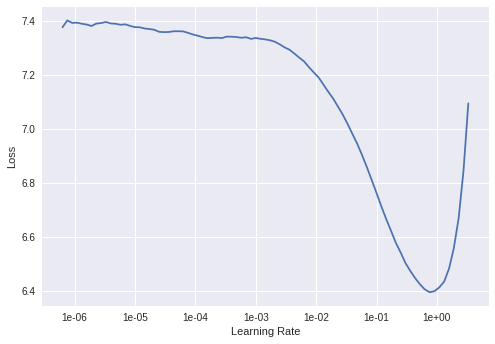

In [0]:
#find optimum learning rate
learn_1.lr_find()
learn_1.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization 
learn_1.fit_one_cycle(cyc_len=1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
1,6.846763,6.320168,0.164035,00:28


Model fine-tuned to 16.4% accuracy in one epoch

In [0]:
#Save fine-tuned model to use in classification
learn_1.save_encoder('ft_enc')

**Train the classifier**

In [0]:
# create classifier using DataBunch created earlier for classification and AWS_LSTM pretrained language model 
drop_mult = 0.5 
learn_1 = text_classifier_learner(data_clas_1, AWD_LSTM, drop_mult=drop_mult)
learn_1.load_encoder('ft_enc')# load fine-tuned learner model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


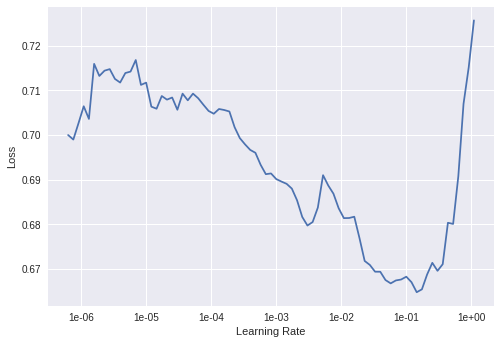

In [0]:
#find optimum learning rate
learn_1.lr_find()
learn_1.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
learn_1.fit_one_cycle(cyc_len=1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
1,0.557326,0.479571,0.761612,00:25


Basic implementation resulted in** 76.2%** accuracy and validation loss is less than training loss. Let's examine what the model is doing.

**Confusion Matrix**

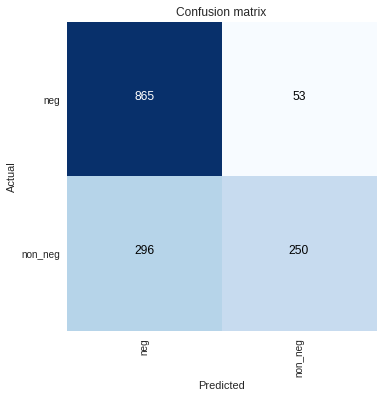

In [0]:
#create confusion matrix 
preds_1,y_1,losses_1 = learn_1.get_preds(with_loss=True)
interp_1 = ClassificationInterpretation(learn_1, preds_1, y_1, losses_1)
interp_1.plot_confusion_matrix()

This Basic implementation seems to be overclassifying non_negative sentiments (positive and neutral) as negative. Let's take a closer look.

**Results**

In [0]:
#Add predictions to validation dataframe
df_val_1['pred'] = df_val_1['text'].apply(lambda row: str(learn_1.predict(row)[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#check data frame 
df_val_1.tail()

,label,text,pred
12811,non_neg,@AmericanAir um no just hanging out what’s new...,neg
2250,neg,@united Flight has been delayed for another ho...,neg
5323,neg,.@SouthwestAir received an error online and ha...,neg
9534,neg,@USAirways What is going on with flight 1826 f...,neg
10679,neg,@USAirways How dirty does the damn plane have ...,neg


In [0]:
#check dataframe info (nulls, colums, types)
df_val_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 12229 to 10679
Data columns (total 3 columns):
label    1464 non-null object
text     1464 non-null object
pred     1464 non-null object
dtypes: object(3)
memory usage: 45.8+ KB


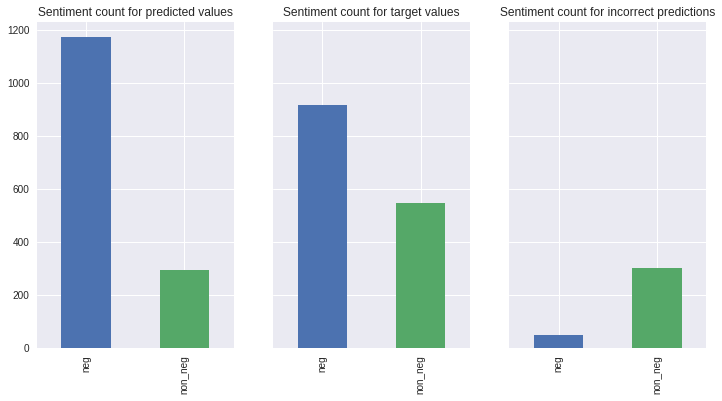

In [0]:
#plot sentiment count for predictions, targets and incorrect predictions.
fig, axarr = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

df_val_1.pred.value_counts().sort_index().plot.bar(
    ax=axarr[0]
)
axarr[0].set_title("Sentiment count for predicted values")

df_val_1.label.value_counts().sort_index().plot.bar(
    ax=axarr[1]
)
axarr[1].set_title("Sentiment count for target values")

df_val_1[df_val_1.label!= df_val_1.pred].label.value_counts().sort_index().plot.bar(
    ax=axarr[2]
)
axarr[2].set_title("Sentiment count for incorrect predictions");


This confirms that our model is overpredicting negative values (or incorrectly classifying non_negative values as negatives). Let's check the Tweets.

In [0]:
#check a sample of incorrectly classified tweets.
df_val_1[df_val_1.label!= df_val_1.pred].tail(10)

,label,text,pred
773,non_neg,"@united flight ua3576, gate b1. And tell ray I...",neg
919,neg,@united empathizes w/ my disappointment that 1...,non_neg
127,non_neg,@VirginAmerica completely awesome experience l...,neg
4573,non_neg,@SouthwestAir can you tell me if flight 805 fr...,neg
6846,non_neg,"@JetBlue Hi there, any rough idea of when Janu...",neg
5016,non_neg,@SouthwestAir last week I flew from DAL to LAX...,neg
7453,non_neg,@JetBlue what a great experience on flight fro...,neg
5680,non_neg,@SouthwestAir sent,neg
9394,non_neg,@USAirways @AmericanAir shout out to Diane at ...,neg
12811,non_neg,@AmericanAir um no just hanging out what’s new...,neg


In [0]:
#negative tweet predicted as non_negative
df_val_1.loc[919].text

'@united empathizes w/ my disappointment that 1stClass flight w/nonworking entertainmnt is worth $50. #UnFriendlySkies http://t.co/lOecO4gmvd'

Tweet above is predicted as non_negative. Model seems to be picking the work "empathize" over the rest for classifying.

In [0]:
#non_negative tweet predicted as negative
df_val_1.loc[7453].text

'@JetBlue what a great experience on flight from SFO to JFK; seats, service, food, everything is top quality. I will be back. Very soon!'

This tweet above is predicted as negative. Which baffles me, as there are no negative words. Maybe model doesn't know what to do with words ike SFO and JFK.

In [0]:
#non_negative tweet predicted as negative
df_val_1.loc[12811].text

'@AmericanAir um no just hanging out what’s new w you?'

Another non_negative (neutral) tweet predicted as negative. Model seems to be using the word no to determine that this is a negative tweet.

Model can definetly be improved by using Deep Learning Hyper-parametric fine-tuning techniques.

## **Improved Implementation**

**Preprocess Data for ULMfiT**

In [0]:
#split data into train 90%, validate 10% as per fastai deep_learning course (lesson 10)
df_trn_2, df_val_2 = train_test_split(data_df, stratify=data_df['label'], test_size = 0.1, random_state = 83)

df_trn_2.shape, df_val_2.shape

((13176, 2), (1464, 2))

In [0]:
#select batch-size for classifier
bs=32 #default for TextClasDataBunch
# create a DataBunch (fastai data object) for Language Model
data_lm_2 = TextLMDataBunch.from_df(train_df = df_trn_2, valid_df = df_val_2, path = "", min_freq=1)

# create a DataBunch (fastai data object) for RNN classifier using vocab from language model
data_clas_2 = TextClasDataBunch.from_df(path = "", train_df = df_trn_2, valid_df = df_val_2, vocab=data_lm_2.train_ds.vocab, bs=bs, min_freq=1)

In [0]:
# check how data looks after preprocessing
data_lm_2.show_batch()

idx,text
0,"book a flight because of outdated , forced opt - in "" xxmaj verified by xxmaj visa "" nonsense . xxmaj help a girl out ? i just want to get to @sxsw xxbos @united just 1 last thing . u guys should n't be charging $ for drinks on a transatlantic flight xxbos @americanair what 's the status of flight 1357 out of sju ? xxbos @americanair good care"
1,you clearly did n't care about our troubles yday thought i 'd share bags took > 90min and came back absolutely drenched .. xxbos @americanair well we cleared customs in xxup auh . i need to get to xxup iah after i arrive in xxup dfw . xxmaj is it possible to retrieve my luggage in xxup iad ? xxbos @usairways the flight that i did not connect to was
2,is beyond ridiculous . xxmaj some steering problem delays us again . # neveragain it 's no wonder you had to sell xxbos @united xxmaj what a really xxup great & & xxup flattering story about you ! xxmaj you should be very proud :) http : / / t.co / oktukjy92o ( via @parachuteguy ) xxbos @virginamerica i applied over 2 weeks ago . xxmaj have n't heard back
3,"@united just got my lost xxmaj kindle in the mail ! xxmaj thanks again . xxbos @jetblue xxmaj yep , still waiting for bags at # xxup jfk . xxmaj what 's the holdup ? xxmaj looks like we are the only flight that got in at this time .. ? ? xxbos @united xxmaj do you have any flights with lie flat seating from xxup stl to xxup pdx"
4,xxmaj please than xxmaj robin at xxup ewr xxmaj premiere xxmaj desk for helping me get on a an earlier flight . xxmaj she did the work . xxmaj huge thanks . xxbos @jetblue xxup @tsa jetblue never disappoints ! xxbos @usairways xxup us 728 / xxmaj feb 21 . xxmaj arrive 7 hrs xxmaj late xxmaj flight ; checked car seat missing . xxmaj no replacement available . xxmaj


**Language Model Fine-tuning**

In [0]:
#create learner model using pretrained dataset AWD_LSTM Merity et. al https://arxiv.org/abs/1708.02182 from fastai
drop_mult=0.1
learn_2 = language_model_learner(data_lm_2, AWD_LSTM, drop_mult=drop_mult)

In [0]:
#check structue of learner model
list(learn_2.model.children())

[AWD_LSTM(
   (encoder): Embedding(15095, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(15095, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=15095, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


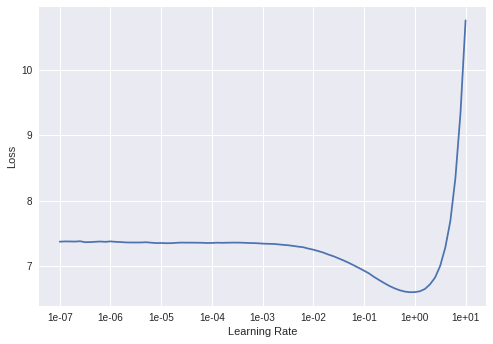

In [0]:
#find optimum learning rate
learn_2.lr_find(start_lr=1e-8, end_lr=1e2)
learn_2.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_2.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.816808,6.281889,0.164844,00:28


Accuracy is **16.5%**,  almost the same accuracy as with the basic implementation. So we unfreeze the model and continue training. 

In [0]:
# unfreeze model and continue training for 15 epochs
learn_2.unfreeze()
learn_2.fit_one_cycle(cyc_len=15, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,5.786323,5.217152,0.206083,00:35
2,5.168601,4.476050,0.244838,00:35
3,4.600520,4.193370,0.263728,00:35
4,4.232181,4.059202,0.271987,00:35
5,3.968616,3.984220,0.279325,00:35
6,3.683970,3.980080,0.279213,00:35
7,3.419349,4.019758,0.279269,00:35
8,3.139668,4.090762,0.274693,00:35
9,2.893517,4.186374,0.270480,00:35
10,2.677337,4.283485,0.266769,00:35


Accuracy increase  to **26.1%** and validation loss decreased from  **6.28** to **4.48.**

In [0]:
#save fine-tuned model to use for classification 
learn_2.save_encoder('ft_enc')

**Train the classifier**

In [0]:
# create classifier using DataBunch created earlier for classification and AWS_LSTM pretrained language model 
drop_mult = 0.5
learn_2 = text_classifier_learner(data_clas_2, AWD_LSTM, drop_mult=drop_mult)
learn_2.load_encoder('ft_enc')

In [0]:
#freeze learning 
learn_2.freeze()



I'll apply gradual unfreezing as it is shown to improve accuracy https://arxiv.org/abs/1801.06146

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


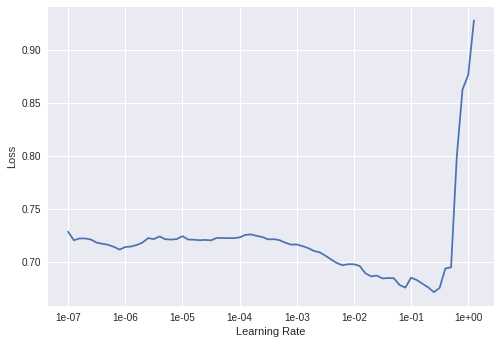

In [0]:
#find optimum learning rate
learn_2.lr_find(start_lr=1e-8, end_lr=1e2)
learn_2.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_2.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.546112,0.455472,0.781421,00:24


This already shows imporvement from Basic Implementation with accuracy of **78.1%** vs. **76.2%**. Lets continue training classifier.

In [0]:
#Unfreeze  one layer
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_2.freeze_to(-2)
learn_2.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.503972,0.398741,0.814208,00:28


In [0]:
#Unfreeze  additional layer
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_2.freeze_to(-3)
learn_2.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.489567,0.373823,0.833333,00:45


In [0]:
#Unfreeze  all
#train model 15 epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_2.unfreeze()
learn_2.fit_one_cycle(15, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.468826,0.365977,0.838798,01:01
2,0.485950,0.367022,0.835383,01:01
3,0.482658,0.370144,0.837432,01:01
4,0.457390,0.351785,0.841530,01:02
5,0.465989,0.361781,0.832650,01:00
6,0.461249,0.357360,0.837432,01:00
7,0.440344,0.335019,0.853142,01:01
8,0.424277,0.332266,0.849727,01:01
9,0.429196,0.331989,0.850410,01:02
10,0.409236,0.325432,0.853825,01:02


Accuracy improved to **86.1%!.** And our validation loss is less than training loss, so the model is not overfitting. Let's explore the results.

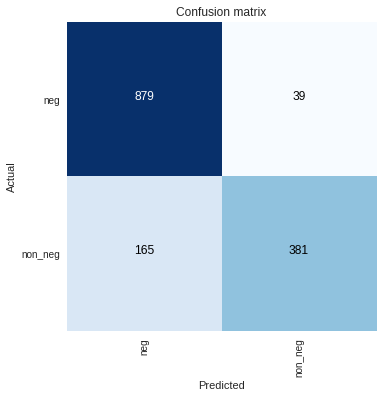

In [0]:
#create confusion matrix
preds_2,y_2,losses_2 = learn_2.get_preds(with_loss=True)
interp_2 = ClassificationInterpretation(learn_2, preds_2, y_2, losses_2)
interp_2.plot_confusion_matrix()

This Fine-tuned implementation seems to be still be overclassifying non_negative sentiments (positive and neutral) as negative. Let's take a closer look.

**Results**

In [0]:
#Add predictions to validation dataframe
df_val_2['pred'] = df_val_2['text'].apply(lambda row: str(learn_2.predict(row)[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#check dataframe
df_val_2.tail()

,label,text,pred
12811,non_neg,@AmericanAir um no just hanging out what’s new...,neg
2250,neg,@united Flight has been delayed for another ho...,neg
5323,neg,.@SouthwestAir received an error online and ha...,neg
9534,neg,@USAirways What is going on with flight 1826 f...,neg
10679,neg,@USAirways How dirty does the damn plane have ...,neg


In [0]:
#check dataframe info (nulls, types, columns)
df_val_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 12229 to 10679
Data columns (total 3 columns):
label    1464 non-null object
text     1464 non-null object
pred     1464 non-null object
dtypes: object(3)
memory usage: 45.8+ KB


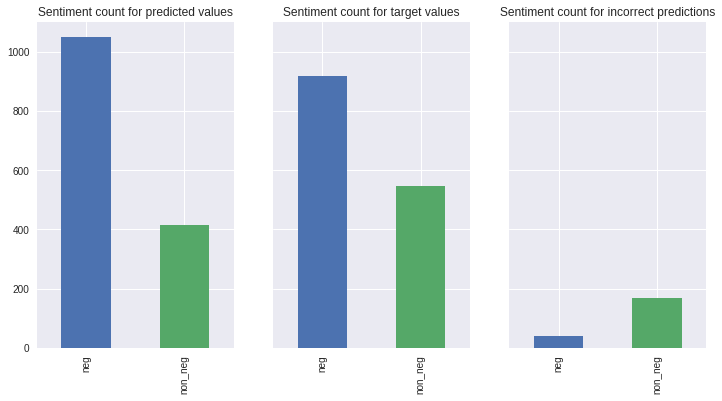

In [0]:
#plot predictions, targets, incorrect predictions
fig, axarr = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

df_val_2.pred.value_counts().sort_index().plot.bar(
    ax=axarr[0]
)
axarr[0].set_title("Sentiment count for predicted values")

df_val_2.label.value_counts().sort_index().plot.bar(
    ax=axarr[1]
)
axarr[1].set_title("Sentiment count for target values")

df_val_2[df_val_2.label!= df_val_2.pred].label.value_counts().sort_index().plot.bar(
    ax=axarr[2]
)
axarr[2].set_title("Sentiment count for incorrect predictions");


Model is still overprediucting negative sentiments. Let's explore the Tweets.

In [0]:
#check sample of incorrectly predicted Tweets
df_val_2[df_val_2.label!= df_val_2.pred].tail(10)

,label,text,pred
355,neg,@VirginAmerica what happened to direct flights...,non_neg
12607,neg,@AmericanAir #2298. Everyone else was outstan...,non_neg
7107,non_neg,@JetBlue but Virgin has wifi 👀,neg
13397,non_neg,@AmericanAir at LAX &amp; just got off the pho...,neg
773,non_neg,"@united flight ua3576, gate b1. And tell ray I...",neg
14583,neg,"@AmericanAir Nah, just horrible dining options...",non_neg
12083,neg,“@AmericanAir: @Andrew_Wasila We're sorry you ...,non_neg
4250,non_neg,"@United just played the Most bizarre ""safety"" ...",neg
9394,non_neg,@USAirways @AmericanAir shout out to Diane at ...,neg
12811,non_neg,@AmericanAir um no just hanging out what’s new...,neg


In [0]:
# negative tweet predicted as non_neg.
df_val_2.text.loc[12607]

'@AmericanAir #2298. Everyone else  was outstanding.'

Model picks on the word outstanding. Doesn't seem to understant context.

In [0]:
#non_negative tweet predicted as negative
df_val_2.text.loc[9394]

'@USAirways @AmericanAir shout out to Diane at EYW for helping get us home today instead of tomorrow (even if a little Late Flight!)'

Model might be classifying shout and late as negative.

In [0]:
#non_negative tweet predicted as negative
df_val_2.text.loc[773]

"@united flight ua3576, gate b1. And tell ray I somehow made it on to the 736 flight out of IAH and didn't have to wait for the 917 one. :)"

Model doesn't understand smiley faces? IT could be predicting negative because of the word wait or t might be thrown off by words like ua3576, b1, IAH, 736, 917.

Let's try to improve the model by separating non_negs in neutral and positive, as the original dataset. This might also backfire as classification models usually work better for binary and balanced classes.

## **Fine-tuned model but with three classes (negative, positive, neutral)**

**Preprocess Data for ULMfiT**

In [0]:
# create dataframe consisting of labels and text only as suggested by Yann LeCun et. al https://arxiv.org/pdf/1509.01626.pdf
data_df_2 = pd.DataFrame()
data_df_2['label'] = df['airline_sentiment']
data_df_2['text'] = df['text'].copy()
data_df_2.head() #check dataframe

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
#check dataframe size
data_df_2.shape

(14640, 2)

In [0]:
#check dataframe info (nulls, columns, types)
data_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
label    14640 non-null object
text     14640 non-null object
dtypes: object(2)
memory usage: 228.8+ KB


In [0]:
#split data into train 90%, validate 10% as per fastai deep_learning course (lesson 10)
df_trn_3, df_val_3 = train_test_split(data_df_2, stratify=data_df_2['label'], test_size = 0.1, random_state = 83)

df_trn_3.shape, df_val_3.shape

((13176, 2), (1464, 2))

In [0]:
#select batch-size for classifier
bs=32 #default for TextClasDataBunch
# create a DataBunch (fastai data object) for Language Model
data_lm_3 = TextLMDataBunch.from_df(train_df = df_trn_3, valid_df = df_val_3, path = "", min_freq=1)

# create a DataBunch (fastai data object) for RNN classifier using vocab from language model
data_clas_3 = TextClasDataBunch.from_df(path = "", train_df = df_trn_3, valid_df = df_val_3, vocab=data_lm_3.train_ds.vocab, bs=bs, min_freq=1)

In [0]:
#check preprocessed data
data_lm_3.show_batch()

idx,text
0,/ / t.co / ttlwzgiyag xxbos @jetblue i 'm over that honestly just would like to get going on the journey . xxbos xxmaj this shits got ta stop xxup rt @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / peq90pqmpp xxbos @united should hire extra customer service reps . 50 minute wait time to ask one question ? i would rather just fly
1,out car rental changes and such . xxbos @usairways why are your customer service department so intent on ignoring my emails and queries ? # badservice # usairways xxbos @united i was n't asking for a full refund but delaying me 3 hours and giving no reason should be enough to give partial credit xxbos @southwestair suggestion- shades on the windows @kciairport so travelers wo n't have to watch ur
2,you for xxmaj christmas . xxbos @americanair thank you for doing the best you could to get me rebooked . xxmaj agent on phone & & addtl resolution on xxup dm was very much appreciated . xxbos @united you 'd learn if you listen to your customers ... you do want you want ... @virginamerica asks their customer what they want xxbos @virginamerica xxmaj you guys charged me $ 100
3,large rifle case too ? xxmaj was n't clear in freq asked questions xxbos @southwestair it would be nice if i could talk to an agent rather than get caught up w / a promotion & & then be hung up on xxbos @jetblue i waited in line all that time to be told by a crewmember that there 's no update until 9:30 # 3hrdelay # disappointed xxbos @united
4,game called xxmaj who can be the xxmaj bigger xxmaj dick to xxmaj people . xxmaj flight 952 to xxup chi - xxup mid xxbos @southwestair what to do when you show up to your destination with no clothes in your suitcase ? # nakedmeetings # awkward xxbos @jetblue # 1680 xxmaj super smooth flight and landing . xxmaj nicely done . xxbos @united i just sent a long note


**Language Model Fine-tuning**

In [0]:
#create learner model using pretrained dataset AWD_LSTM Merity et. al https://arxiv.org/abs/1708.02182 from fastai
drop_mult=0.1
learn_3 = language_model_learner(data_lm_3, AWD_LSTM, drop_mult=drop_mult)

In [0]:
#check structure of learner model
list(learn_3.model.children())

[AWD_LSTM(
   (encoder): Embedding(15119, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(15119, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=15119, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


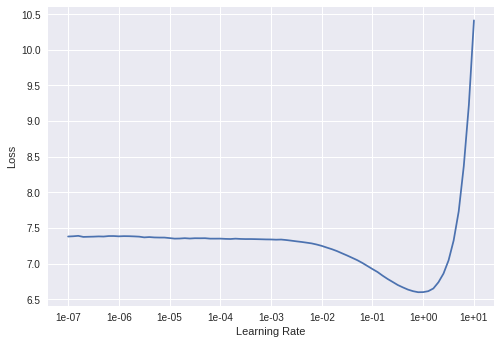

In [0]:
#find optimum learning rate
learn_3.lr_find(start_lr=1e-8, end_lr=1e2)
learn_3.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_3.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.815966,6.316790,0.161607,00:29


Accuracy is similar to previous models: **16.2%**

In [0]:
# unfreeze model and continue training for 15 epochs
learn_3.unfreeze()
learn_3.fit_one_cycle(cyc_len=15, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,5.788518,5.239578,0.200992,00:35
2,5.167732,4.499863,0.241691,00:35
3,4.598574,4.213074,0.258036,00:35
4,4.227964,4.065394,0.269767,00:35
5,3.942227,4.008253,0.275818,00:35
6,3.668914,3.999787,0.279415,00:35
7,3.400664,4.035471,0.276116,00:35
8,3.149117,4.407180,0.250794,00:35
9,2.897838,4.200648,0.270709,00:35
10,2.676928,4.274826,0.268378,00:35


Similar to previous model, after further training, accuracy increaces to **26.3%.**

In [0]:
#save fine-tuned model to use for classification 
learn_3.save_encoder('ft_enc')

**Train the classifier**

In [0]:
# create classifier using DataBunch created earlier for classification and AWS_LSTM pretrained language model 
drop_mult = 0.5
learn_3 = text_classifier_learner(data_clas_3, AWD_LSTM, drop_mult=drop_mult)
learn_3.load_encoder('ft_enc')

In [0]:
#freeze learning
learn_3.freeze()



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


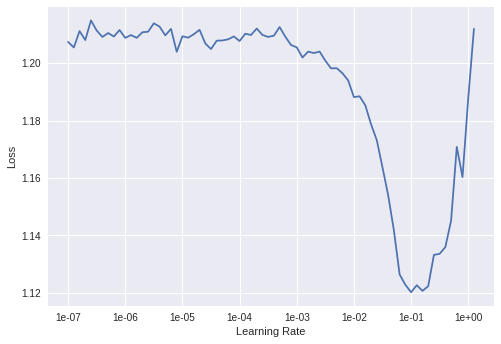

In [0]:
#find optimum learning rate
learn_3.lr_find(start_lr=1e-8, end_lr=1e2)
learn_3.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_3.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.755149,0.616269,0.741803,00:24


And now we get a lower accuracy than with both previous models at **74.2%**. Let's continue training to see if it improves.

In [0]:
#Unfreeze  one layer
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_3.freeze_to(-2)
learn_3.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.698049,0.583948,0.761612,00:28


In [0]:
#Unfreeze  additional layer
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_3.freeze_to(-3)
learn_3.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.660167,0.535460,0.776639,00:47


In [0]:
#Unfreeze all
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_3.unfreeze()
learn_3.fit_one_cycle(15, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.647775,0.533825,0.774590,01:01
2,0.639680,0.521395,0.782104,00:59
3,0.642863,0.511909,0.787568,01:00
4,0.598835,0.493893,0.794399,01:01
5,0.597074,0.496806,0.800546,01:02
6,0.591990,0.478784,0.806011,01:01
7,0.561893,0.463800,0.814208,01:02
8,0.579383,0.463342,0.818989,01:01
9,0.535792,0.466089,0.816257,01:01
10,0.549344,0.469352,0.818989,01:02


With **82.4%** accuracy, this model is more accurate than the basic implementation but its not more accurate than the binary model fine-tuned. Let's check the results to see what is going on.

**Confusion Matrix**

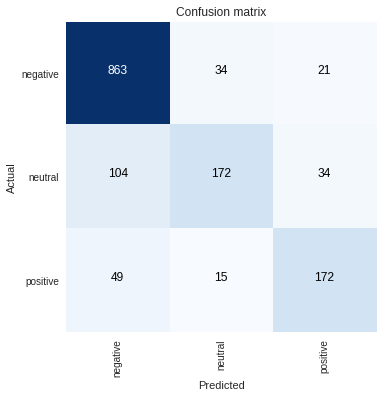

In [0]:
#create confusion matrix
preds_3,y_3,losses_3 = learn_3.get_preds(with_loss=True)
interp_3 = ClassificationInterpretation(learn_3, preds_3, y_3, losses_3)
interp_3.plot_confusion_matrix()

The model seems to be misclassifying neutrals as negative. Let's check the tweets.

**Results**

In [0]:
#Add predictions to validation dataframe
df_val_3['pred'] = df_val_3['text'].apply(lambda row: str(learn_3.predict(row)[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#check dataframe
df_val_3.tail()

,label,text,pred
2951,negative,@united flight 5187 to be specific. The last t...,negative
3888,negative,@united we are never going to get to out gate ...,negative
2161,negative,@united has once again earned a place as the w...,negative
14370,negative,@AmericanAir I have been on hold 3 hours. 2 s...,negative
9184,negative,@USAirways honestly - how is it quickly as pos...,negative


In [0]:
#check dataframe info (nulls, columsn, type)
df_val_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 3885 to 9184
Data columns (total 3 columns):
label    1464 non-null object
text     1464 non-null object
pred     1464 non-null object
dtypes: object(3)
memory usage: 45.8+ KB


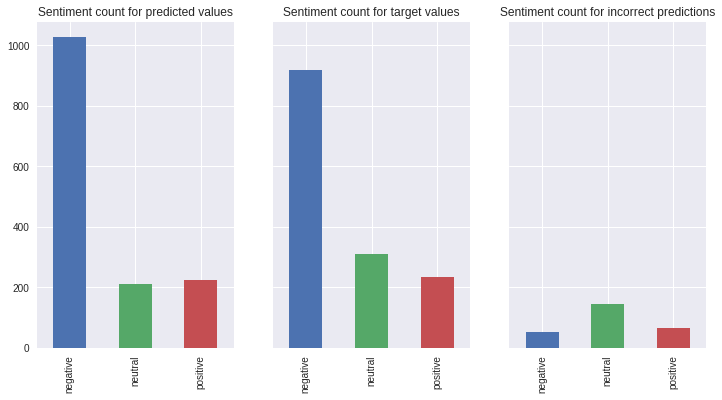

In [0]:
#plot predictions, targets, incorrect predictions
fig, axarr = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

df_val_3.pred.value_counts().sort_index().plot.bar(
    ax=axarr[0]
)
axarr[0].set_title("Sentiment count for predicted values")

df_val_3.label.value_counts().sort_index().plot.bar(
    ax=axarr[1]
)
axarr[1].set_title("Sentiment count for target values")

df_val_3[df_val_3.label!= df_val_3.pred].label.value_counts().sort_index().plot.bar(
    ax=axarr[2]
)
axarr[2].set_title("Sentiment count for incorrect predictions");


This model is overclassifying neutral as negatives. Comparatively, it doesn't do thsat bad with positive twees.

In [0]:
#check sample of incorrect predictions
df_val_3[df_val_3.label!= df_val_3.pred].tail(10)

,label,text,pred
355,negative,@VirginAmerica what happened to direct flights...,neutral
12607,negative,@AmericanAir #2298. Everyone else was outstan...,positive
11243,neutral,@USAirways can they change to correct last nam...,negative
813,neutral,@united I hope so too,positive
8408,neutral,@JetBlue Brazil to volunteer teaching english...,negative
9202,neutral,@USAirways but i bougth mc caren to jfk with s...,negative
14583,negative,"@AmericanAir Nah, just horrible dining options...",positive
11420,negative,@usairways would it kill you to let me put my ...,neutral
3020,positive,@united enjoyed #heathrow lounge so much i alm...,negative
6951,neutral,@JetBlue @weepysweetmonty i heard youre planni...,negative


In [0]:
#negative tweet predicted as positive
df_val_3.text.loc[14583]

'@AmericanAir Nah, just horrible dining options outside of club. Luckily Manuel in the Admirals can make a Bloody Mary.'

Negative tweet predicted as positive. Baffling as has negative words Nah and horrible. Positive words , luckily, admirals?

In [0]:
#positive tweet predicted as negative
df_val_3.text.loc[3020]

'@united enjoyed #heathrow lounge so much i almost missed my @airnzusa flight!'

Not sure if its the word missed or the overuse of tweet language (@, #)

In [0]:
#neutral tweet predicted as positive
df_val_3.text.loc[813]

'@united I hope so too'

Tweet above is labeled neutral and predicted as positive. Probably the word hope.

In [0]:
#neutral tweet predicted as negative
df_val_3.text.loc[6951]

'@JetBlue @weepysweetmonty i heard youre planning on letting people fly in the overhead compartments. why would you do that?'

Neutral tweet predicted as negative. I actually agree with the model, it seems more negative than neutral.

In [0]:
#neutral tweet predicted as negative
df_val_3.text.loc[8408]

'@JetBlue  Brazil to volunteer teaching english &amp; spanish to Poor children so they have a skills to improve their chances of a better life.'

Tweet above labeled as neutral, predicted as negative, maybe because it mentiones Poor children?

So adding the neutral class did not improve the model. Let's try removing the neutral tweets as the model does not seem to do well with them. This should imporve the model as it returns it to a binary classification problem, though unbalanced.

## **Model without neutral tweets**

**Preprocess Data for ULMfiT**

In [0]:
# create dataframe consisting of labels and text only as suggested by Yann LeCun et. al https://arxiv.org/pdf/1509.01626.pdf
data_df_3 = pd.DataFrame()
data_df_3['label'] = df['airline_sentiment']
data_df_3['text'] = df['text'].copy()
data_df_3.head()#check dataframe

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
#check size
data_df_3.shape

(14640, 2)

In [0]:
#remove neutral tweets
data_df_3 = data_df_3[data_df_3.label != 'neutral']

In [0]:
#check datsframe info (nulls, columns, types)
data_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11541 entries, 1 to 14638
Data columns (total 2 columns):
label    11541 non-null object
text     11541 non-null object
dtypes: object(2)
memory usage: 270.5+ KB


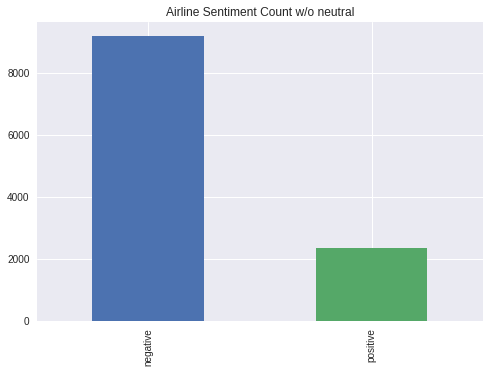

In [0]:
#check class distribution
data_df_3.label.value_counts().plot(kind='bar', title='Airline Sentiment Count w/o neutral');

In [0]:
#split data into train 90%, validate 10% as per fastai deep_learning course (lesson 10)
df_trn_4, df_val_4 = train_test_split(data_df_3, stratify=data_df_3['label'], test_size = 0.1, random_state = 83)

df_trn_4.shape, df_val_4.shape

((10386, 2), (1155, 2))

In [0]:
#select batch-size for classifier
bs=32 #default for TextClasDataBunch
# create a DataBunch (fastai data object) for Language Model
data_lm_4 = TextLMDataBunch.from_df(train_df = df_trn_4, valid_df = df_val_4, path = "", min_freq=1)

# create a DataBunch (fastai data object) for RNN classifier using vocab from language model
data_clas_4 = TextClasDataBunch.from_df(path = "", train_df = df_trn_4, valid_df = df_val_4, vocab=data_lm_4.train_ds.vocab, bs=bs, min_freq=1)

In [0]:
# check how data looks after preprocessing
data_lm_4.show_batch()

idx,text
0,"ramp was broken . "" xxmaj no other ramps in xxmaj charlotte ? ? xxbos @united that would be great - 1k us651621 xxbos @usairways tell them to get on that , please . xxbos @southwestair i xxup would xxup do xxup anything xxup for tickets to the xxup vegas ... xxup anything . i love imagine dragons so much ! ! xxbos @jetblue xxmaj been a member since 2007"
1,"service on xxup sw xxbos @jetblue xxmaj flight 1562 is still waiting for bags . xxmaj most of us checked in 12 hours ago . xxmaj people are missing connections . xxmaj please help ! xxbos @southwestair you guys rock ! xxmaj so easy , quick , and affordable to change my flight . # bestairlineever # neverchange xxbos @usairways xxmaj that link does n't work on mobile . xxbos"
2,sitting in a bus without air in front of plane and there is no communication from anyone40min xxbos @jetblue sounds great ! xxmaj thank you ! ! :) xxbos @usairways i get some bs from a guy at the door says door closes 10 minutes before it backs out . xxmaj yet i know for a fact it was 5 people short xxbos @americanair has the worst flights and customer
3,"phone . xxmaj do you actually have any employees ? xxbos @americanair not to mention its a three hour wait to get an agent on the phone . xxbos @usairways not happy w / app xxmaj late xxmaj flightly . xxmaj last time i flew would n't let me check in , xxmaj this time i checked in went on xxmaj late xxmaj flightr says i never checked in xxbos"
4,"your staff at xxup lax really messed up on this one . xxmaj failing to scan my suitcase tag . xxbos @united should hire extra customer service reps . 50 minute wait time to ask one question ? i would rather just fly another airline , thanks . xxbos @southwestair xxmaj hi - xxmaj my flight ( xxup bna to xxup lga ) was xxmaj cancelled xxmaj flighted this morning--"


**Language Model Fine-tuning**

In [0]:
#create learner model using pretrained dataset AWD_LSTM Merity et. al https://arxiv.org/abs/1708.02182 from fastai
drop_mult=0.1
learn_4 = language_model_learner(data_lm_4, AWD_LSTM, drop_mult=drop_mult)

In [0]:
#check learner structure
list(learn_4.model.children())

[AWD_LSTM(
   (encoder): Embedding(12694, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(12694, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=12694, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


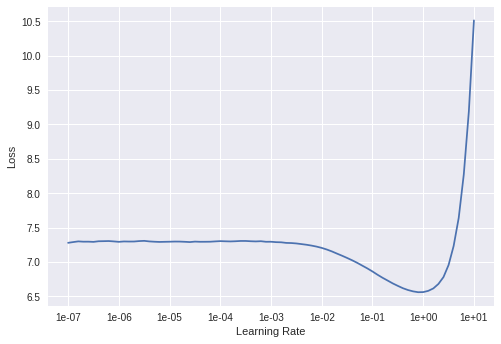

In [0]:
#find optimum learning rate
learn_4.lr_find(start_lr=1e-8, end_lr=1e2)
learn_4.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_4.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.863474,6.356096,0.158100,00:22


At **15.8%**, accuracy is a little lower than in all previous models, but not that much. Let's continue training.

In [0]:
# unfreeze model and continue training for 15 epochs
learn_4.unfreeze()
learn_4.fit_one_cycle(cyc_len=15, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,5.897778,5.281853,0.197385,00:28
2,5.351610,4.698582,0.221014,00:28
3,4.759184,4.273860,0.250574,00:28
4,4.346770,4.096588,0.266167,00:28
5,4.043130,4.040946,0.269005,00:28
6,3.765982,4.034140,0.271875,00:28
7,3.517258,4.067775,0.269133,00:28
8,3.236789,4.131282,0.266901,00:28
9,2.979490,4.239089,0.262341,00:28
10,2.748489,4.325390,0.257653,00:28


Again, accuracy is a little lower than in previous models at **25.2%**, but its improving, and validation loss is improving too.

In [0]:
#save fine-tuned model to use for classification 
learn_4.save_encoder('ft_enc')

**Train the classifier**

In [0]:
# create classifier using DataBunch created earlier for classification and AWS_LSTM pretrained language model 
drop_mult = 0.5
learn_4 = text_classifier_learner(data_clas_4, AWD_LSTM, drop_mult=drop_mult)
learn_4.load_encoder('ft_enc')

In [0]:
#freeze learning
learn_4.freeze()



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


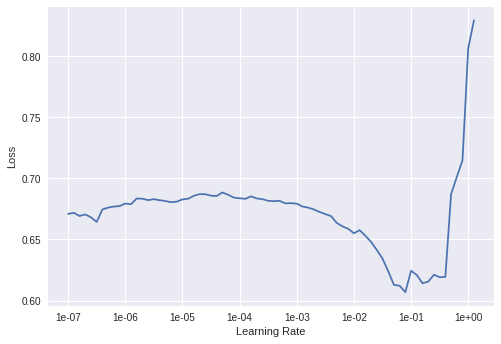

In [0]:
#find optimum learning rate
learn_4.lr_find(start_lr=1e-8, end_lr=1e2)
learn_4.recorder.plot()

In [0]:
#train model w/ max learning rate 1e-3, one epoch, using fit_one cycle that already provides some regularization
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_4.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.420883,0.251649,0.894372,00:19


**89.4%** accuracy, that is better than all other models so far. Let's continue training.

In [0]:
#Unfreeze  one layer
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_4.freeze_to(-2)
learn_4.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.338225,0.193074,0.914286,00:22


In [0]:
#Unfreeze  additional layer
#train model one epoch, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_4.freeze_to(-3)
learn_4.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.331057,0.193903,0.913420,00:36


In [0]:
#Unfreeze  all
#train model 15 epochs, using fit_one cycle that already provides some regularization
# using a different learning rates for each layer for fine-tuning
# include moms to decrease momentum so that we train faster and don't overshoot target
learn_4.unfreeze()
learn_4.fit_one_cycle(15, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.313016,0.185741,0.916883,00:47
2,0.299098,0.186880,0.916017,00:50
3,0.305828,0.176552,0.922944,00:48
4,0.309566,0.170958,0.929870,00:47
5,0.292763,0.170470,0.926407,00:48
6,0.282157,0.163103,0.930736,00:48
7,0.282879,0.168165,0.929004,00:47
8,0.249387,0.166886,0.929004,00:47
9,0.233395,0.170528,0.929870,00:48
10,0.224902,0.163241,0.934199,00:49


We improved accuracy to **93.1%!**, and the model is not overfitting! Let's take a look at what the model is doing.

**Confusion Matrix**

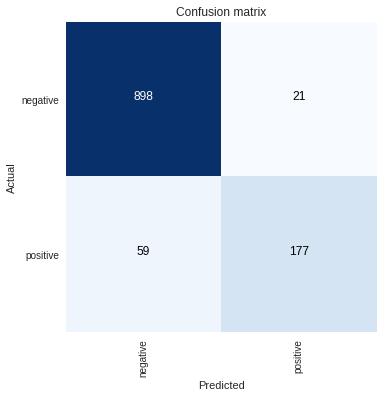

In [0]:
#create confusion mattrix
preds_4,y_4,losses_4 = learn_4.get_preds(with_loss=True)
interp_4 = ClassificationInterpretation(learn_4, preds_4, y_4, losses_4)
interp_4.plot_confusion_matrix()

Model still tends to over predict negatives, but that is expected due to the class imbalance.

**Results**

In [0]:
#Add predictions to validation dataframe
df_val_4['pred'] = df_val_4['text'].apply(lambda row: str(learn_4.predict(row)[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#check dataframe
df_val_4.tail()

,label,text,pred
1011,positive,Thank you “@united: @TRUU_Tall I can certainly...,positive
5506,positive,@SouthwestAir you are lucky to have people lik...,positive
5150,negative,@SouthwestAir baggage claim has already change...,negative
13950,negative,@AmericanAir I have tried to talk to someone f...,negative
14383,positive,@AmericanAir Always enjoy my time. Now on the ...,positive


In [0]:
#check dataframe info (nulls, columns, types)
df_val_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1155 entries, 10176 to 14383
Data columns (total 3 columns):
label    1155 non-null object
text     1155 non-null object
pred     1155 non-null object
dtypes: object(3)
memory usage: 36.1+ KB


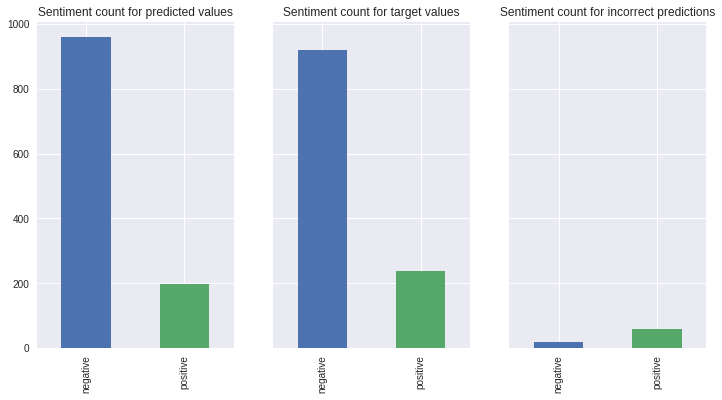

In [0]:
#plot predictions, targets, incorrect predictions
fig, axarr = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

df_val_4.pred.value_counts().sort_index().plot.bar(
    ax=axarr[0]
)
axarr[0].set_title("Sentiment count for predicted values")

df_val_4.label.value_counts().sort_index().plot.bar(
    ax=axarr[1]
)
axarr[1].set_title("Sentiment count for target values")

df_val_4[df_val_4.label!= df_val_4.pred].label.value_counts().sort_index().plot.bar(
    ax=axarr[2]
)
axarr[2].set_title("Sentiment count for incorrect predictions");


As expected, model is slightly overpredicting negative values. Let's explore.

In [0]:
#check incorrect predictions
df_val_4[df_val_4.label!= df_val_4.pred].tail(10)

,label,text,pred
10485,positive,@USAirways No Problem - he was the only person...,negative
3998,positive,@united Got me home amid snow &amp; Cancelled ...,negative
11795,positive,@USAirways customer service at its finest,negative
3021,positive,"@united Hi, flight 1051. If I try and book a n...",negative
7552,negative,@JetBlue unfortunately I was so startled and r...,positive
9432,negative,"@usairways really need help asap, so please ma...",positive
8254,positive,@JetBlue Same exact flight too. Love JetBlue. ...,negative
6812,positive,"@JetBlue Annnndddd, I just booked my flight. T...",negative
8318,positive,@JetBlue Then en route to the airport the rebo...,negative
11545,positive,@USAirways we are boarding now but have yet to...,negative


In [0]:
#negative tweet predicted positive
df_val_4.text.loc[7552]

"@JetBlue unfortunately I was so startled and rushed, I didn't get the name, but will provide a description in my expanded email.  Thank you"

Thank you at the end of tweet makes it predict positive.

In [0]:
#negative tweet predicted positive
df_val_4.text.loc[9432]

'@usairways really need help asap, so please make it quick. Thx.'

Probably same as abaove, maybe the thanks make it predict positive. Or politeness in general (please, help, Thks)

In [0]:
#positive tweet predicted negative
df_val_4.text.loc[10485]

'@USAirways No Problem - he was the only person in the airport who would help :)'

Again, model doesn't seem understand smiley face, and probably words No and Problem count as negative.

In [0]:
#positive tweet predicted negative
df_val_4.text.loc[3998]

'@united Got me home amid snow &amp; Cancelled Flightlations; delivered bag w/o hassle; plus no wait on phone &amp; an upgrade. Thank you!'

No idea why this positive tweet is predicted as negative, maybe words like cancelled and hassle, and thank you does not make it positive as thought before.

**Conclusions**

Accuracy was improved from **76.2%** to **93.1%**  through hyper-parameter fine-tuning, feature engineering and, further exploration of results. Could it be improved further? Probably. I only touched upon hyper-parameter fine-tuning, trying to keep models as same as possible to compare results, but each model iteration could have its own hyper-parameter fine-tuning. Additional, language modelling could also be included, instead of using the AWS_LSTM another pretrained model could be used, maybe one more specifically trained for tweets or sentiment. Data preprocessing could also have been done differently. Additionally, I did not explore other classification  or deep learning models. It could be that they provide a better result. I quickly checked Kaggle for results and I did find at least one with better results https://www.kaggle.com/robertq/language-model-for-sentiment-analysis

**Resources**

https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde

https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-10-transfer-learning-nlp.md

https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

https://docs.fast.ai/index.html

http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html

https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv

https://arxiv.org/abs/1803.09820

https://arxiv.org/abs/1801.06146

